In [ ]:
'''
Author: Claire Morehouse
Description: This lab using Python package Pandas to import PUDs - Planned Unit Development - shapefile for DC and an affordable housing dataset and
turns the afforable housing csv into a geodataframe and merges the shapefile and the csv file based on the geographic intersection. A master geodataframe
is created containing the information about zoning exemptions as well as affordable housing projects at the same geographic locations. The final step 
merges this with the a zoning categories crosswalk to get the zoning cateogories in "plain english." The final output is a map of the PUDs that offer 
affordable housing.
Inputs: PUDs Shapefile, Affordable Housing CSV, Zoning Crosswalks CSV
Outputs: Map of PUDS by zoning category, map of just the PUDS that provide affordable housing 
'''

In [1]:
# Add gis packages to colab environment
!pip install geopandas
!apt-get install -y libspatialindex-dev
!pip install rtree

# Then import packages
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join

     |████████████████████████████████| 972kB 5.7MB/s 
     |████████████████████████████████| 6.5MB 14.5MB/s 
     |████████████████████████████████| 14.8MB 327kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 12 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 2s (275 kB/s)
Selecting previously un

In [2]:
from google.colab import drive
drive.mount('/content/gdrive') # connects Colab to your Google Drive
root_path = 'gdrive/My Drive/gis/' # set root path to folder where you uploaded the data

Mounted at /content/gdrive


In [4]:
# Read in PUDs file as a geodataframe and initialize coordinate reference system (CRS)
puds = gpd.read_file(root_path+'input/Planned_Unit_Development__PUDs_.shp', crs = {'init' :'epsg:4326'})
aff = pd.read_csv(root_path+'input/Affordable_Housing.csv')
crosswalk = pd.read_csv(root_path+'input/zoning_crosswalk.csv')

In [5]:
# Running this code grabs rows from the first 3 index places (4 rows total!)
puds.sample(3)

,OBJECTID,PUD_NAME,PUD_WEB_UR,PUD_CHANGE,PUD_ZONING,PUD_STATUS,PUD_CASE_N,GLOBALID,WARD,SHAPEAREA,SHAPELEN,geometry
271,147780,Stanton Square LLC,https://app.dcoz.dc.gov/Content/Search/ViewCas...,"MC of Consolidated PUD, Approved 10/21/19, DC ...","R-5-A, SP-1",Final,13-09C,{D4EF39CA-C066-4554-855B-D4F904CC4C84},Ward 8,0,0,"POLYGON ((-76.98687 38.85618, -76.98675 38.856..."
207,147716,Terrace Manor Redevelopment LP,https://app.dcoz.dc.gov/Content/Search/ViewCas...,Setdown 02/10/20,None,Pending,19-19,{CBCDDFF1-9C3B-46C9-BBEB-2946DDF70D85},Ward 8,0,0,"POLYGON ((-76.97211 38.84846, -76.97197 38.848..."
254,147763,Professional Associates and International Fina...,https://app.dcoz.dc.gov/Content/Search/ViewCas...,"Case # 14-04 Set Down 4/15/14, Approved 12/5/14",None,Final,14-04A,{ADFD194D-3875-49AC-BD59-1B2C55FB7489},Ward 2,0,0,"POLYGON ((-77.04867 38.90234, -77.04725 38.902..."


In [6]:
# This gives you a summary of what is within the Affordable housing .csv
aff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   X                              518 non-null    float64
 1   Y                              518 non-null    float64
 2   OBJECTID                       518 non-null    int64  
 3   MAR_WARD                       517 non-null    object 
 4   ADDRESS                        513 non-null    object 
 5   PROJECT_NAME                   518 non-null    object 
 6   STATUS_PUBLIC                  518 non-null    object 
 7   AGENCY_CALCULATED              518 non-null    object 
 8   TOTAL_AFFORDABLE_UNITS         518 non-null    int64  
 9   LATITUDE                       513 non-null    float64
 10  LONGITUDE                      514 non-null    float64
 11  AFFORDABLE_UNITS_AT_0_30_AMI   518 non-null    int64  
 12  AFFORDABLE_UNITS_AT_31_50_AMI  518 non-null    int

In [7]:
# This gives you a summary of what is within the PUD .shp file
puds.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    298 non-null    int64   
 1   PUD_NAME    298 non-null    object  
 2   PUD_WEB_UR  298 non-null    object  
 3   PUD_CHANGE  296 non-null    object  
 4   PUD_ZONING  298 non-null    object  
 5   PUD_STATUS  298 non-null    object  
 6   PUD_CASE_N  298 non-null    object  
 7   GLOBALID    298 non-null    object  
 8   WARD        298 non-null    object  
 9   SHAPEAREA   298 non-null    int64   
 10  SHAPELEN    298 non-null    int64   
 11  geometry    298 non-null    geometry
dtypes: geometry(1), int64(3), object(8)
memory usage: 28.1+ KB


In [8]:
# Create a geometry column in the affordable housing dataframe
aff['geometry'] = aff.apply(lambda row: Point(row.X, row.Y), axis=1)
aff = gpd.GeoDataFrame(aff, crs={'init' :'epsg:4326'})

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [9]:
aff.sample(1) #sampling to the first index... or column headers and one row.

,X,Y,OBJECTID,MAR_WARD,ADDRESS,PROJECT_NAME,STATUS_PUBLIC,AGENCY_CALCULATED,TOTAL_AFFORDABLE_UNITS,LATITUDE,LONGITUDE,AFFORDABLE_UNITS_AT_0_30_AMI,AFFORDABLE_UNITS_AT_31_50_AMI,AFFORDABLE_UNITS_AT_51_60_AMI,AFFORDABLE_UNITS_AT_61_80_AMI,AFFORDABLE_UNITS_AT_81_AMI,CASE_ID,ADDRESS_ID,XCOORD,YCOORD,FULLADDRESS,GIS_LAST_MOD_DTTM,geometry
322,-77.001611,38.905805,1300,Ward 6,"300 M Street Northeast, Washington, District o...",300 M Street NE,Pipeline,DHCD OP,35,38.905798,-77.001609,0,0,7,28,0,14-19,NaN,399860.480364,137548.887561,NaN,2020/11/09 04:00:32+00,POINT (-77.00161 38.90581)


In [10]:
# Use geospatial join to identify which PUDs include affordable housing projects
puds_aff = gpd.sjoin(puds, aff, op='intersects', how='left')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs

  


In [11]:
# Check our Merge - incremental development, we're checking as we go!
puds_aff.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 305 entries, 0 to 297
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   OBJECTID_left                  305 non-null    int64   
 1   PUD_NAME                       305 non-null    object  
 2   PUD_WEB_UR                     305 non-null    object  
 3   PUD_CHANGE                     303 non-null    object  
 4   PUD_ZONING                     305 non-null    object  
 5   PUD_STATUS                     305 non-null    object  
 6   PUD_CASE_N                     305 non-null    object  
 7   GLOBALID                       305 non-null    object  
 8   WARD                           305 non-null    object  
 9   SHAPEAREA                      305 non-null    int64   
 10  SHAPELEN                       305 non-null    int64   
 11  geometry                       305 non-null    geometry
 12  index_right                 

In [12]:
# Merge dataframe with zoning categories crosswalk
puds_info = puds_aff.merge(crosswalk[['Zone_Cat']], how='left', left_on='PUD_ZONING', right_on=crosswalk['Zone'])

In [13]:
# Quick count using print statements to show us how many PUDs there are total, and how many offer affordable housing.

print(f"Total count of PUDs: {puds_info.shape[0]}")
print(f"Count PUDs offering Affordable Housing: {puds_info.loc[~puds_info.PROJECT_NAME.isna()].shape[0]}")

Total count of PUDs: 305
Count PUDs offering Affordable Housing: 78


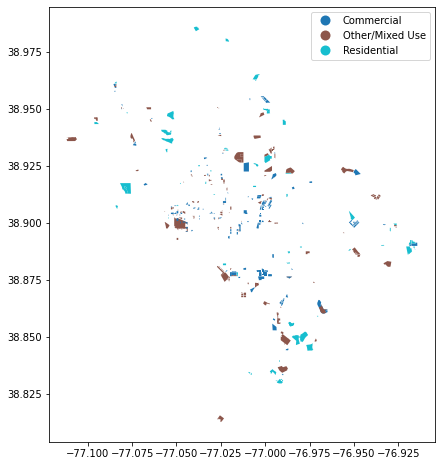

In [14]:
# Create a map of PUDs by Zoning Category
puds_info.plot(column='Zone_Cat', legend=True, figsize=(16,8));

/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:573: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


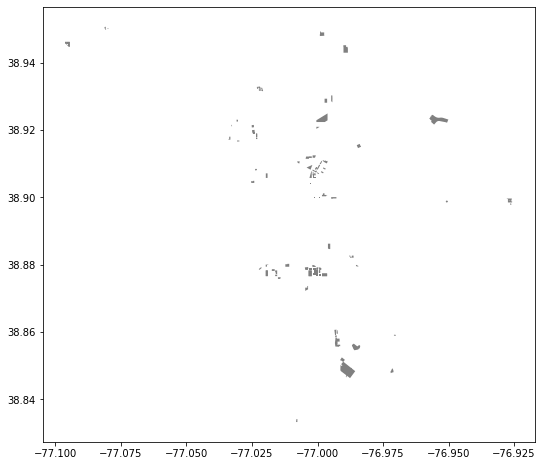

In [15]:
# Create a map of just the PUDs that provide Affordable Housing
puds_info[puds_info['TOTAL_AFFORDABLE_UNITS']>0].plot(column='TOTAL_AFFORDABLE_UNITS', color='grey', figsize=(16,8));

In [16]:
# Export geodataframe as shapefile within Colab environment
puds_info.to_file('puds_info.shp')

# Copy shapefile components from Colab environment to Google Drive using bash script
!cp puds_info.cpg 'gdrive/My Drive/gis/output'
!cp puds_info.dbf 'gdrive/My Drive/gis/output'
!cp puds_info.prj 'gdrive/My Drive/gis/output'
!cp puds_info.shp 'gdrive/My Drive/gis/output'
!cp puds_info.shx 'gdrive/My Drive/gis/output'